In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [2]:
RANDOM_STATE = 42

# Read Data

In [3]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [4]:
read_query = make_read_query()

In [5]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,purchases,revenue,purchased_categories,created_at,first_purchase_date,last_purchase_date
0,61226,30,M,United States,Mesquite,Search,0,0.00,[None],2021-12-06 08:35:00,NaT,NaT
1,15498,16,M,United States,Lincoln,Organic,1,25.00,[Sleep & Lounge],2024-01-14 04:24:00,2024-01-15 00:49:47,2024-01-15 00:49:47
2,41490,61,M,United States,Murrayville,Search,0,0.00,[None],2021-07-05 07:54:00,NaT,NaT
3,84974,18,M,China,Chengdu,Search,20,1035.38,"[Underwear, Sweaters, Sweaters, Outerwear & Co...",2021-06-17 17:55:00,2022-08-30 18:03:20,2024-01-09 16:21:17
4,98865,44,M,United States,Pharr,Search,1,259.99,[Suits & Sport Coats],2020-11-25 02:09:00,2023-11-29 23:31:26,2023-11-29 23:31:26


In [6]:
users_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84011 entries, 0 to 84010
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    84011 non-null  int64         
 1   age                   84011 non-null  int64         
 2   gender                84011 non-null  object        
 3   country               84011 non-null  object        
 4   city                  84011 non-null  object        
 5   traffic_source        84011 non-null  object        
 6   purchases             84011 non-null  int64         
 7   revenue               84011 non-null  float64       
 8   purchased_categories  84011 non-null  object        
 9   created_at            84011 non-null  datetime64[ns]
 10  first_purchase_date   69073 non-null  datetime64[ns]
 11  last_purchase_date    69073 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(3), object(5)
memory usage: 7.7+ M

In [7]:
users_enriched.describe()

,id,age,purchases,revenue,created_at,first_purchase_date,last_purchase_date
count,84011.000000,84011.000000,84011.000000,84011.000000,84011,69073,69073
mean,50059.769102,41.059897,7.370951,439.676297,2021-06-14 10:42:19.902129920,2022-07-16 08:15:15.045710848,2023-01-26 22:31:06.887598848
min,1.000000,12.000000,0.000000,0.000000,2019-01-02 00:06:00,2019-01-06 02:25:41,2019-01-07 01:23:18
25%,25094.500000,26.000000,1.000000,22.000000,2020-02-20 04:11:00,2021-09-13 00:20:14,2022-08-05 16:38:29
50%,50125.000000,41.000000,2.000000,108.400000,2021-05-23 03:56:00,2022-10-20 18:26:08,2023-06-03 21:57:37
75%,75022.500000,56.000000,9.000000,455.980000,2022-09-24 04:51:30,2023-07-30 10:50:57,2023-11-09 01:02:14
max,100000.000000,70.000000,270.000000,17963.080000,2024-01-16 19:46:14.316147,2024-01-21 10:09:51.990337,2024-01-21 18:02:23.533893
std,28861.594335,17.047718,12.909895,867.696928,NaN,NaN,NaN


In [8]:
inactive_users = users_enriched.loc[users_enriched.first_purchase_date.isna()]
active_users = users_enriched.dropna(subset='first_purchase_date')

In [9]:
inactive_users.shape, active_users.shape

((14938, 12), (69073, 12))

# Utility Functions

In [10]:
def plot_histograms(df, columns=None, width=14, height=7, bins=20):
    columns = df.columns if columns is None else columns
    n_subplots = len(columns)
    n_subplot_rows = round(np.sqrt(n_subplots))
    n_subplot_cols = n_subplots / n_subplot_rows

    n_subplot_cols = int(n_subplot_cols) + 1 if n_subplot_cols % 1 > 0 else int(n_subplot_cols)
    
    fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols)
    fig.set_figwidth(14)
    fig.set_figheight(7)

    for i, col in enumerate(columns):
        ax_row = i // n_subplot_cols
        ax_col = i % n_subplot_cols
        ax = axs[ax_row,ax_col]
        ax.set_title(col)
        df[col].hist(bins=bins, ax=ax)

In [11]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []        
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)
        silhouette = silhouette_score(X, y)
        inertia = model.inertia_ if model_type == KMeans else None
        
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model, 
            'silhouette_score': silhouette,
            'inertia': inertia if inertia else cost
        }
        
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Inertia: {inertia}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [12]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

In [13]:
now = active_users.last_purchase_date.max()
now

Timestamp('2024-01-21 18:02:23.533893')

In [14]:
df_lifetime = active_users.copy()
df_lifetime['active_days'] = (df_lifetime.last_purchase_date - df_lifetime.first_purchase_date).dt.days + 1
df_lifetime['inactive_days'] = (now - df_lifetime.last_purchase_date).dt.days
df_lifetime['purchase_frequency'] = df_lifetime['purchases'] / df_lifetime['active_days']
df_lifetime['avg_monetization'] = df_lifetime['revenue'] / df_lifetime['purchases']
df_lifetime = df_lifetime[['active_days', 'inactive_days', 'purchase_frequency', 'avg_monetization']]

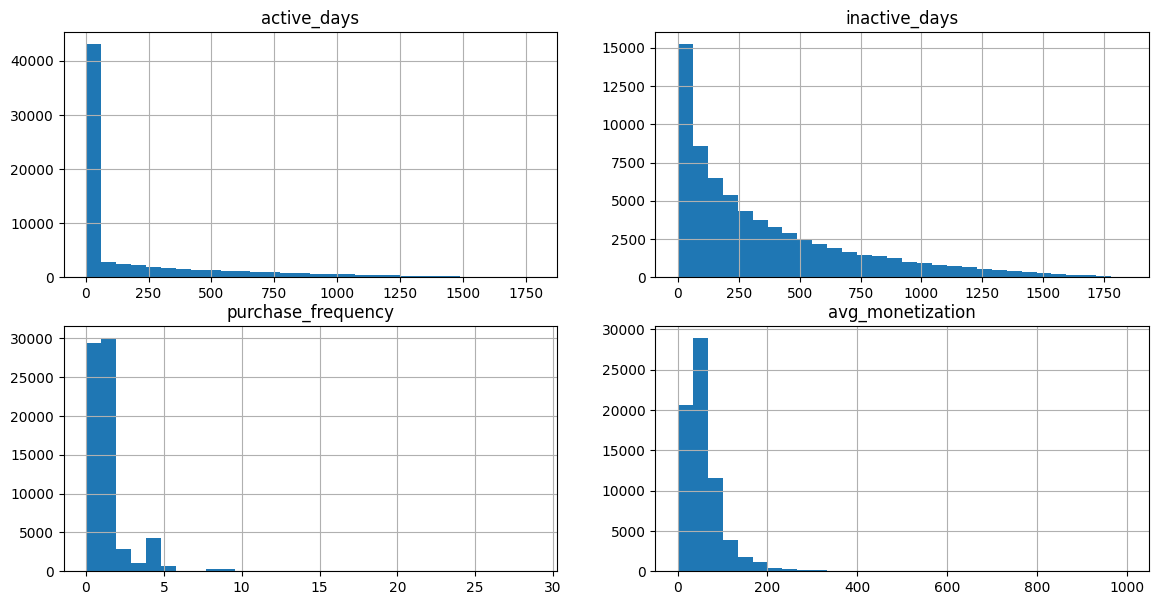

In [15]:
plot_histograms(df_lifetime, bins=30)

<Axes: >

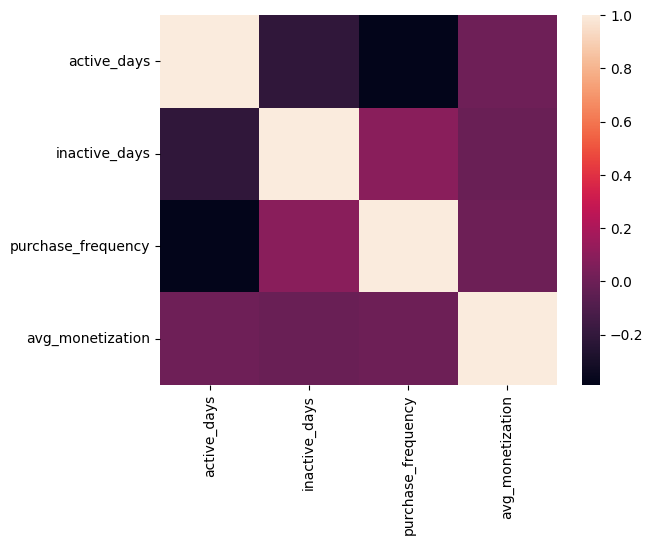

In [16]:
sns.heatmap(df_lifetime.corr())

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(df_lifetime)

In [18]:
hyperparams = [{'n_clusters': i} for i in range(2, 11)]
df_results = search_clustering_hyperparams(KMeans, hyperparams, X, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.28278178885868693 | Inertia: 217157.60196174448
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.3294167291474734 | Inertia: 177549.56504761413
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.379238284776757 | Inertia: 137989.73124750343
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.4027946262887691 | Inertia: 99786.47464184635
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.33431028937115836 | Inertia: 90573.51652880691
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.30749564389291845 | Inertia: 83081.70833972628
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.31957627755218077 | Inertia: 73537.19388852369
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.3301960177214932 | Inertia: 63778.32429703788
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.32304247771343647 | Inertia: 58655.24298809295


<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

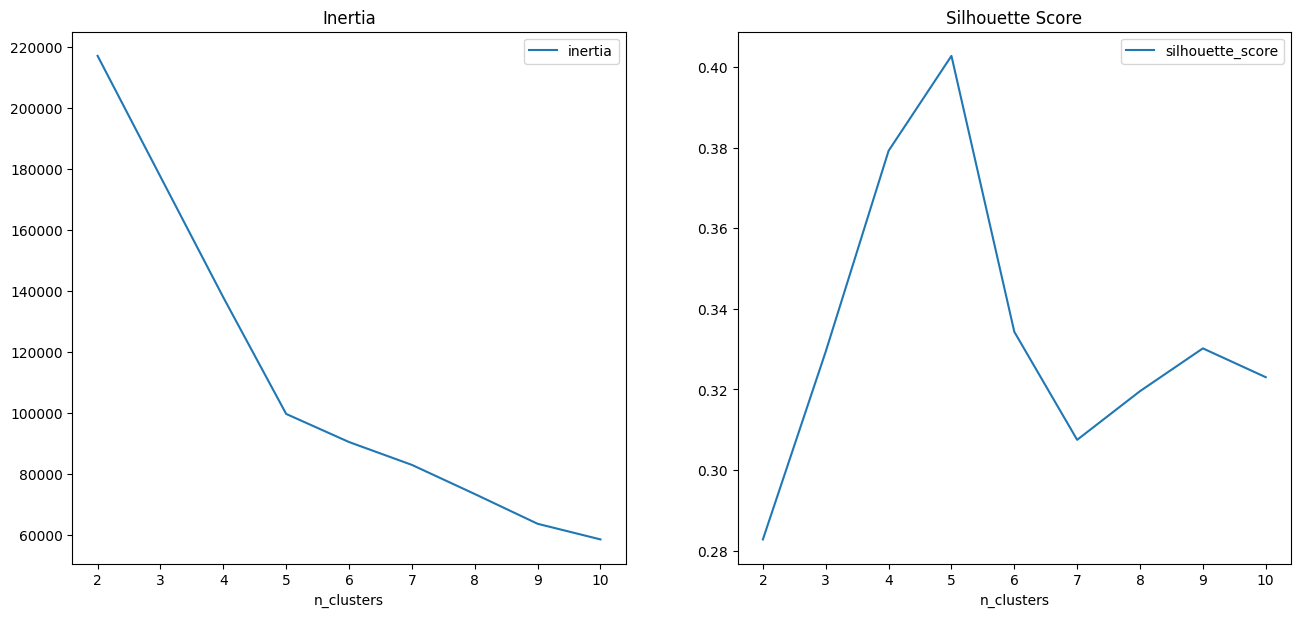

In [23]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
df_results.plot(x='n_clusters', y='inertia', ax=axs[0])

axs[1].set_title('Silhouette Score')
df_results.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [20]:
model = df_results.loc[df_results.n_clusters==5, 'model'].iloc[0]
df_lifetime_cluster = df_lifetime.copy()
df_lifetime_cluster['cluster'] = model.labels_

In [24]:
cluster_centers = scaler.inverse_transform(model.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=df_lifetime.columns)
cluster_centers

,active_days,inactive_days,purchase_frequency,avg_monetization
0,67.422580,362.280401,0.936717,206.277263
1,48.449461,963.585846,1.043184,48.165593
2,831.492063,206.982132,0.026990,57.856378
3,2.246961,310.325229,4.804717,56.358879
4,75.377736,196.262412,0.730139,48.176684


In [25]:
df_lifetime_cluster['cluster'].value_counts()

cluster
4    34456
1    12766
2    12060
3     6004
0     3787
Name: count, dtype: int64

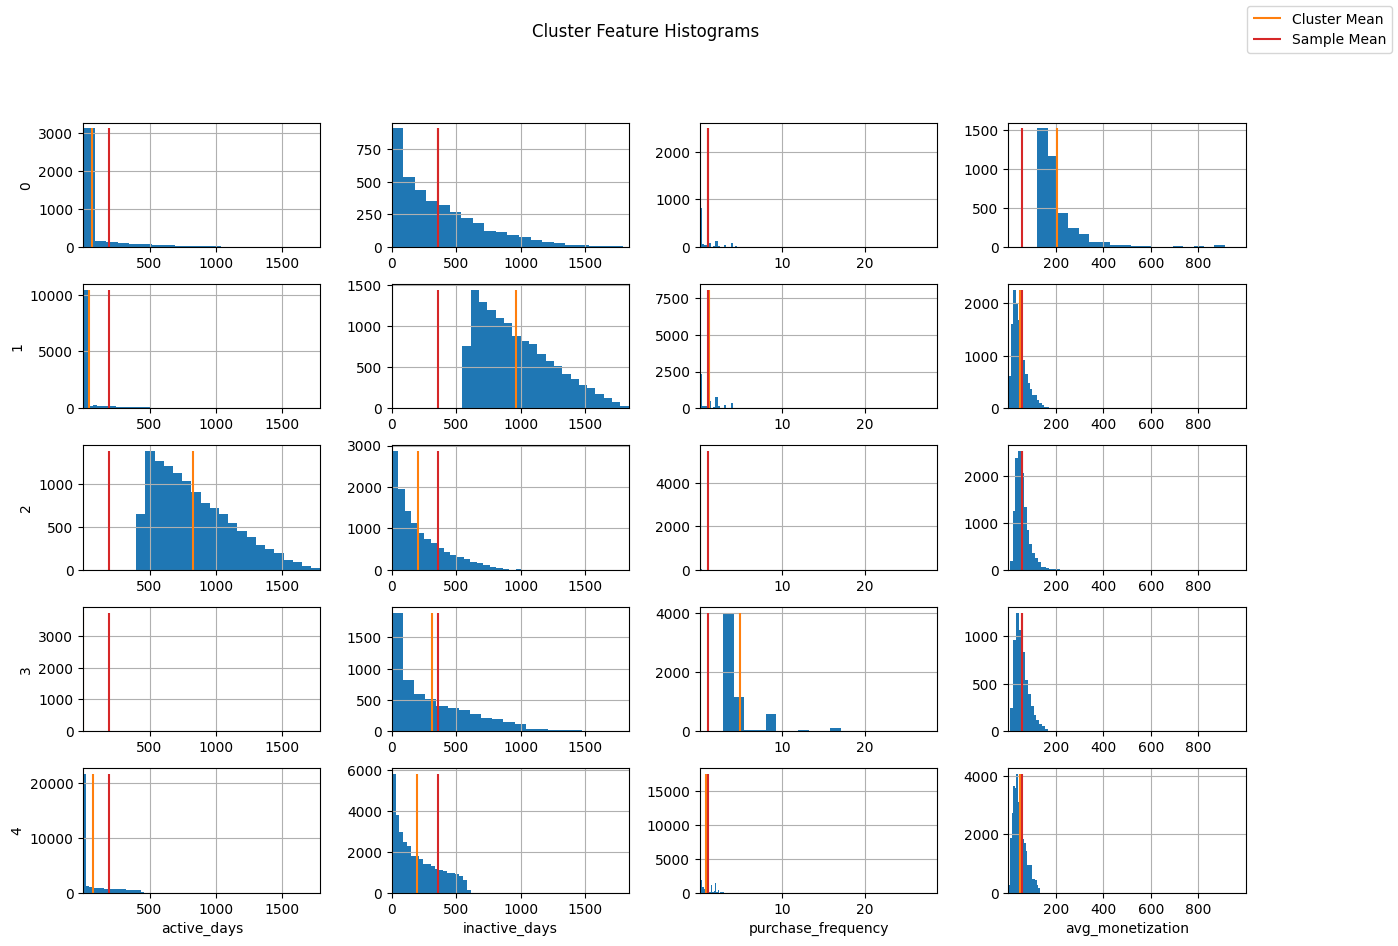

In [27]:
plot_clusters(df_lifetime, model.labels_)

In [28]:
print('Cluster Mean / Sample Mean:', df_lifetime_cluster.groupby('cluster').mean() / df_lifetime_cluster.drop(columns='cluster').mean(), sep='\n')
print('\n'+80*'-'+'\n', 'Cluster Mean:', df_lifetime_cluster.groupby('cluster').mean(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Std:', df_lifetime_cluster.groupby('cluster').std(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Min:', df_lifetime_cluster.groupby('cluster').min(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Max:', df_lifetime_cluster.groupby('cluster').max(), sep='\n')

Cluster Mean / Sample Mean:
         active_days  inactive_days  purchase_frequency  avg_monetization
cluster                                                                  
0           0.344325       1.007917            0.908580          3.482894
1           0.247497       2.684308            1.012832          0.813370
2           4.252890       0.576226            0.026221          0.976205
3           0.011505       0.863164            4.659319          0.950996
4           0.384565       0.547261            0.708487          0.813124

--------------------------------------------------------------------------------

Cluster Mean:
         active_days  inactive_days  purchase_frequency  avg_monetization
cluster                                                                  
0          67.251122     362.218907            0.936960        206.359476
1          48.339417     964.669669            1.044467         48.191691
2         830.644113     207.080348            0.027040      

In [29]:
cluster_4 = df_lifetime[model.labels_==4]
cluster_4

,active_days,inactive_days,purchase_frequency,avg_monetization
1,1,6,1.000000,25.000000
7,74,82,0.054054,45.750000
9,1,71,1.000000,129.880000
11,263,30,0.015209,37.225000
12,1,124,1.000000,19.990000
...,...,...,...,...
83994,1,295,1.000000,24.000000
83996,380,230,0.010526,14.990000
84002,192,476,0.046875,47.983333
84008,1,211,1.000000,16.990000


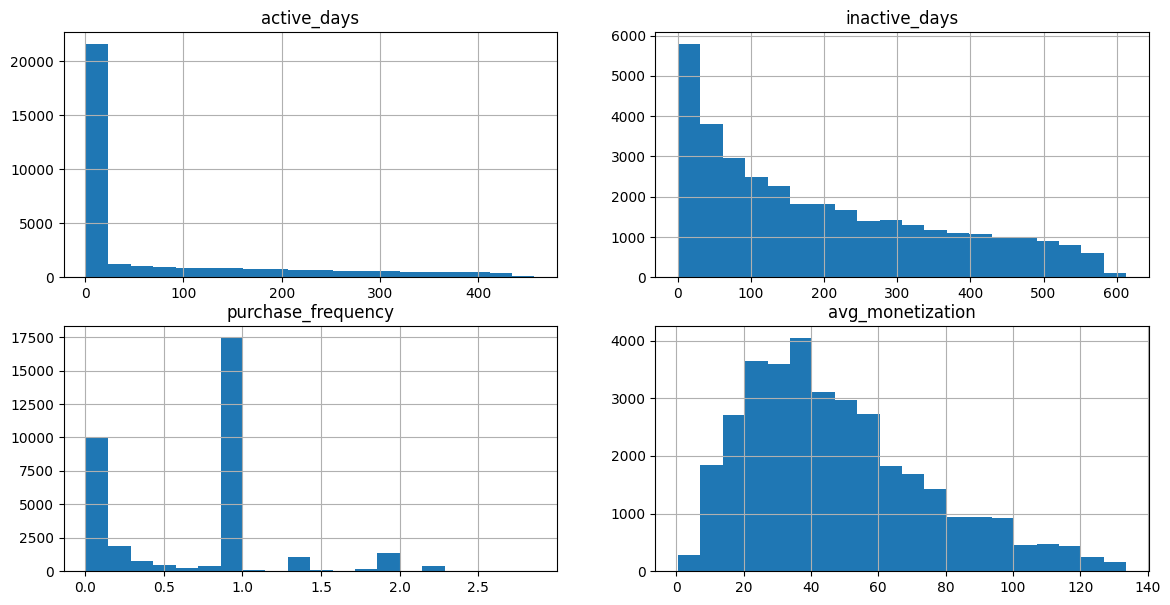

In [30]:
plot_histograms(cluster_4)

In [36]:
scaler_4 = StandardScaler()
X_4 = scaler_4.fit_transform(cluster_4)

In [37]:
hyperparams = [{'n_clusters': i} for i in range(2, 11)]
df_results_4 = search_clustering_hyperparams(KMeans, hyperparams, X_4, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.364118974023016 | Inertia: 88498.46218274023
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.31109428556996715 | Inertia: 70261.32906536423
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.3276765366446763 | Inertia: 56477.76252396309
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.3206920505922507 | Inertia: 48120.90523056076
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.3249148195081716 | Inertia: 43195.76764773186
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.3151948408724393 | Inertia: 39501.06485613203
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.3386787760017726 | Inertia: 34251.78509191662
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.3463167722732631 | Inertia: 30485.6692538053
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.29208878570375807 | Inertia: 30490.203307153326


<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

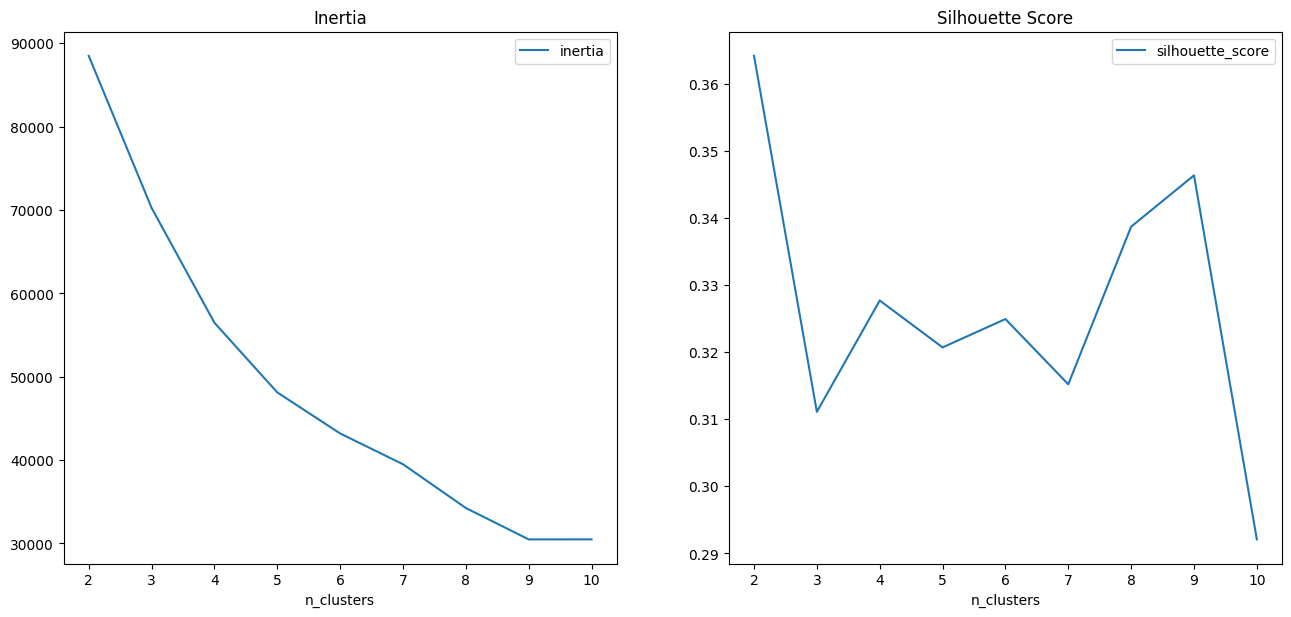

In [40]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
df_results_4.plot(x='n_clusters', y='inertia', ax=axs[0])

axs[1].set_title('Silhouette Score')
df_results_4.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [41]:
model_4 = df_results_4.loc[df_results.n_clusters==9, 'model'].iloc[0]
clustered_4 = cluster_4.copy()
clustered_4['cluster'] = model_4.labels_

In [45]:
clustered_4['cluster'].value_counts()

cluster
5    8711
1    5354
0    4517
6    3613
8    3367
4    2570
3    2442
7    2215
2    1667
Name: count, dtype: int64

In [42]:
cluster_centers_4 = scaler_4.inverse_transform(model.cluster_centers_)
cluster_centers_4 = pd.DataFrame(cluster_centers_4, columns=df_lifetime.columns)
cluster_centers_4

,active_days,inactive_days,purchase_frequency,avg_monetization
0,29.385291,197.972646,0.695412,125.958527
1,22.601754,467.194752,0.735067,42.313489
2,302.566183,128.441050,0.356571,47.440158
3,6.082785,174.710789,2.136104,46.647943
4,32.229531,123.641516,0.618469,42.319357


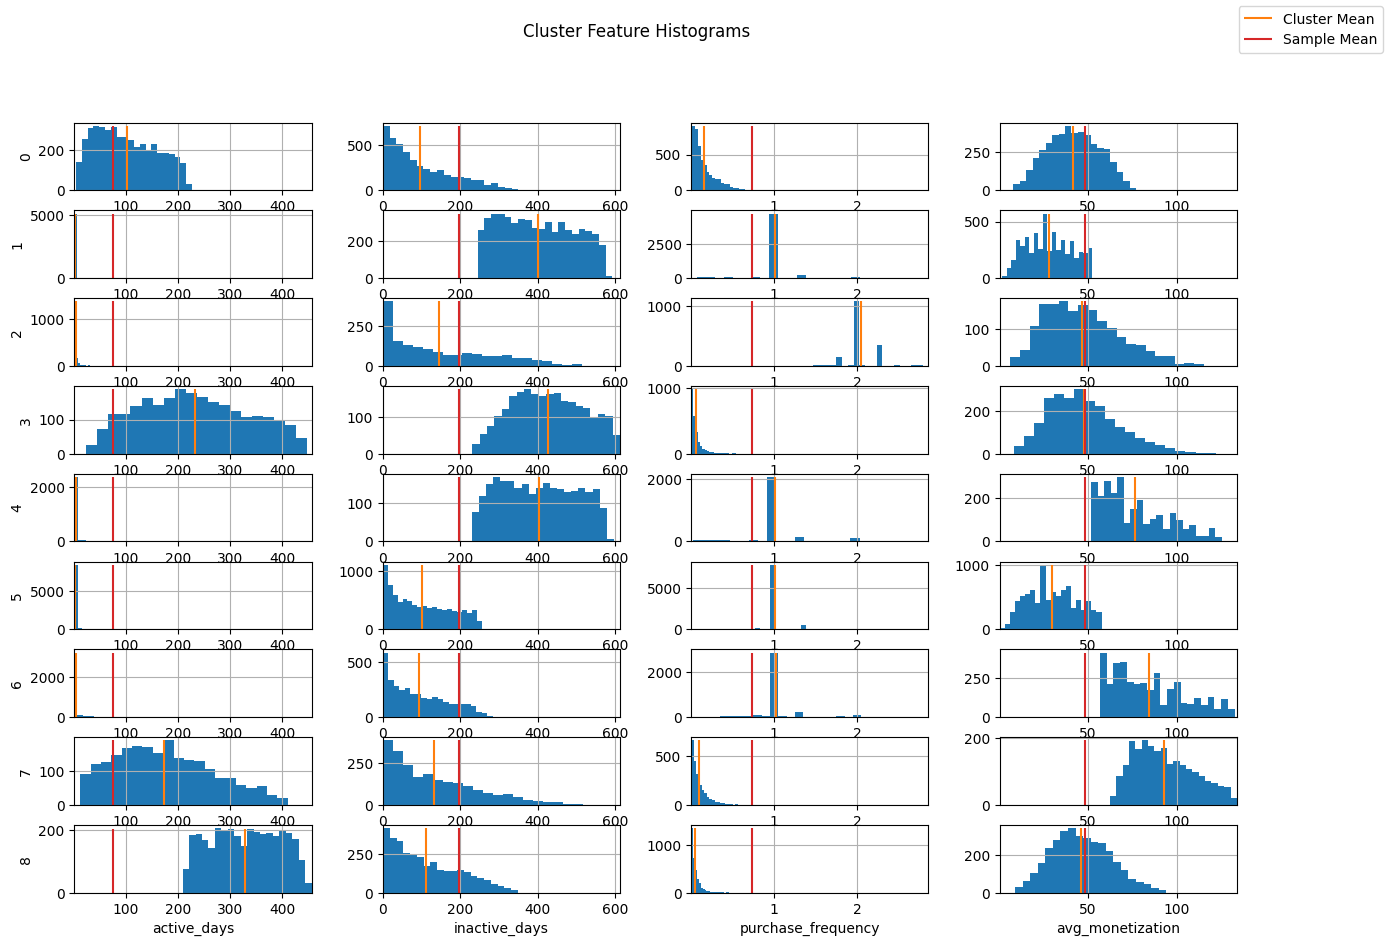

In [44]:
plot_clusters(cluster_4, model_4.labels_)

In [46]:
print('Cluster Mean / Sample Mean:', clustered_4.groupby('cluster').mean() / clustered_4.drop(columns='cluster').mean(), sep='\n')
print('\n'+80*'-'+'\n', 'Cluster Mean:', clustered_4.groupby('cluster').mean(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Std:', clustered_4.groupby('cluster').std(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Min:', clustered_4.groupby('cluster').min(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Max:', clustered_4.groupby('cluster').max(), sep='\n')

Cluster Mean / Sample Mean:
         active_days  inactive_days  purchase_frequency  avg_monetization
cluster                                                                  
0           1.347985       0.492478            0.210324          0.868747
1           0.032431       2.032617            1.384821          0.587005
2           0.051091       0.740413            2.799327          0.974156
3           3.088562       2.170289            0.084218          0.989746
4           0.063735       2.045285            1.389712          1.584204
5           0.032709       0.509611            1.379285          0.625541
6           0.058779       0.471229            1.405176          1.748235
7           2.316246       0.672153            0.136742          1.928160
8           4.388031       0.572544            0.075199          0.962408

--------------------------------------------------------------------------------

Cluster Mean:
         active_days  inactive_days  purchase_frequency  avg_